# Value Iteration for Minimum Time Control

In [1]:
# python libraries
import matplotlib.animation as ani
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
# pydrake imports
from pydrake.all import (DiagramBuilder, DynamicProgrammingOptions,
                         FittedValueIteration, LinearSystem, LogVectorOutput,
                         Simulator, VectorSystem)


## Problem Description
In this problem you will analyze the performance of the value-iteration algorithm on the minimum-time problem for the double integrator.
Don't worry, the value iteration algorithm is provided by Drake, and you won't have to code it!
You will be asked to analyze the policy it produces and understand the algorithmic reasons behind the poor performance of the closed loop system.
Then you will have to implement on your own the closed-form controller we have studied in class, and compare it with the one obtained numerically.

**These are the main steps of the notebook:**
1. Construct the double integrator system.
2. Define the objective function for the minimum time problem.
3. Run the value-iteration algorithm.
4. Animate the intermediate steps of the algorithm.
5. Simulate the double integrator in closed loop with the controller from the value iteration.
6. Write down a controller that implements the closed form solution, and test it.

## Dynamics of the Double Integrator
We start by writing a function that returns the double-integrator system.
We write the dynamics is state-space linear form
$$\dot{\mathbf{x}} = A \mathbf{x} + B u,$$
where $\mathbf{x} = [q, \dot{q}]^T$.

In [2]:
# we write a function since we will need to call
# this a handful of times
def get_double_integrator():
    A = np.array([[0, 1], [0, 0]])
    B = np.array([[0], [1]])
    C = np.eye(2)
    D = np.zeros((2, 1))
    return LinearSystem(A, B, C, D)

## Integrand of the Cost Function
Remember that the minimum-time objective can be written in integral form
$$\int_{0}^{\infty} \ell(\mathbf{x}) dt,$$
by defining
$$\ell(\mathbf{x}) = \begin{cases} 0 & \text{if} \quad \mathbf{x} =0,\\ 1 & \text{otherwise}. \end{cases}$$
(See also [the example from the textbook](https://underactuated.csail.mit.edu/dp.html#minimum_time_double_integrator).)
In the following cell we approximate this with the `numpy` function `isclose`, to be able to handle small numerical errors.

In [3]:
# approximation of the indicator function for the origin
def cost_function(context):
    
    # extract the state from the context of the plant
    x = context.get_continuous_state_vector().CopyToVector()
    
    return 0 if np.isclose(np.linalg.norm(x), 0.) else 1

## Value Iteration Algorithm
The value iteration is implemented in the Drake function
`FittedValueIteration`. Take some time to have a look at [its
documentation](https://drake.mit.edu/doxygen_cxx/group__control.html#gaa8b65fac47fdb50bd891e36bae1cc7d6),
and to go through the description of this algorithm in [the
textbook](https://underactuated.csail.mit.edu/dp.html#barycentric). Before
using it, we need to construct an appropriate discretization of the state and
input space.

**Important:** This code will work if you change the limits of the input to be
different from $u_{\text{min}} = -1$ and $u_{\text{max}} = 1$. However, be
aware that the closed-form solution we derived in class (and that you'll have
to implement at the end of this notebook) is assuming that! It's not hard to
generalize the closed-form solution to the case with generic bounds
$u_{\text{min}}$ and $u_{\text{max}}$. But if you don't want to do that, do not
change `mesh['u_lim']` below!

In [4]:
# discretization mesh of state space, input space,
# and time for the value-iteration algorithm
mesh = {}

# number of knot points in the grids
# odd to have a point in the origin
mesh['n_q'] = 51 # do not exceed ~51/101
mesh['n_qdot'] = 51 # do not exceed ~51/101
mesh['n_u'] = 11  # don't exceed ~11/21

# grid limits
mesh['q_lim'] = [-2., 2.]
mesh['qdot_lim'] = [-2., 2.]
mesh['u_lim'] = [-1., 1.] # do not change

# axis discretization
for s in ['q', 'qdot', 'u']:
    mesh[f'{s}_grid'] = np.linspace(*mesh[f'{s}_lim'], mesh[f'n_{s}'])
    
    # important: ensure that a knot point is in the origin
    # otherwise there is no way the value iteration can converge
    assert 0. in mesh[f'{s}_grid']
    
# time discretization in the value-iteration algorithm
mesh['timestep'] = 0.005

In the following cell we wrap Drake's `FittedValueIteration` function with a function we call `run_value_iteration`.
This returns the optimal value function, the optimal controller, and all the data we need for the upcoming animation.

In [5]:
def run_value_iteration(cost_function, mesh, max_iter=10000):
    
    # to create an animation, we store the values of
    # the cost to go and the optimal policy for each
    # iteration of the value-iteration algorithm
    J_grid = []
    pi_grid = []
    
    # callback from the value-iteration algorithm
    # that saves the intermediate values of J and pi
    # and that ensures we do not exceed max_iter
    # (iteration number i starts from 1)
    def callback(i, unused, J, pi):

        # check max iter is not exceeded
        if i > max_iter:
            raise RuntimeError(f'Value-iteration algorithm did not converge within {max_iter} iterations.')

        # store cost to go for iteration i
        # the 'F' order facilitates the plot phase
        J_grid.append(np.reshape(J, (mesh['n_q'], mesh['n_qdot']), order='F'))
        pi_grid.append(np.reshape(pi, (mesh['n_q'], mesh['n_qdot']), order='F'))

    # set up a simulation
    simulator = Simulator(get_double_integrator())
    
    # grids for the value-iteration algorithm
    state_grid = [set(mesh['q_grid']), set(mesh['qdot_grid'])]
    input_grid = [set(mesh['u_grid'])]
    
    # add custom callback function as a visualization_callback
    options = DynamicProgrammingOptions()
    options.visualization_callback = callback
    
    # run value-iteration algorithm 
    policy, cost_to_go = FittedValueIteration(
        simulator,
        cost_function,
        state_grid,
        input_grid,
        mesh['timestep'],
        options
    )

    # recast J and pi from lists to 3d arrays
    J_grid = np.dstack(J_grid)
    pi_grid = np.dstack(pi_grid)
    
    return policy, cost_to_go, J_grid, pi_grid

## Animation of the Value-Iteration Algorithm
If the following code looks intimidating, no need to fully understand it.
What it does can be summarized as follows:
- runs value iteration,
- initializes an empty 3D surface plot for the value function and the policy,
- creates the function `update_surf` that when called updates the surface plots from the previous point,
- creates a fancy animation by calling `update_surf` many times.

We hope you'll appreciate the final result!

INFO:drake:Computing transition and cost matrices.
INFO:drake:Done computing transition and cost matrices.
INFO:drake:Running value iteration.
INFO:drake:Value iteration converged to requested tolerance.


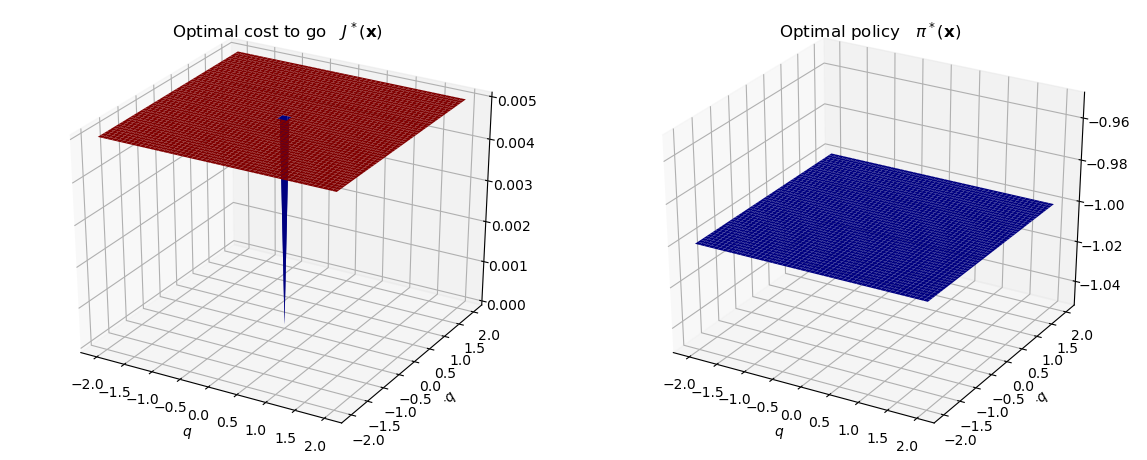

In [6]:
# run value iteration to get the matrices J_grid and pi_grid
policy, cost_to_go, J_grid, pi_grid = run_value_iteration(cost_function, mesh)

# initialize figure for animation plus misc settings
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plt.tight_layout()
ax[0].axis('off')
ax[1].axis('off')

# cost-to-go plot and policy plots
# overwrites the subplots axes
ax[0] = fig.add_subplot(121, projection='3d')
ax[1] = fig.add_subplot(122, projection='3d')
ax[0].set_title(r'Optimal cost to go   $J^*(\mathbf{x})$')
ax[1].set_title(r'Optimal policy   $\pi^*(\mathbf{x})$')
for axi in ax:
    axi.set_xlabel(r'$q$')
    axi.set_ylabel(r'$\dot q$')

# helper function for the surface plot
Q, Qdot = np.meshgrid(mesh['q_grid'], mesh['qdot_grid'])
plot_surf = lambda ax, Z : ax.plot_surface(Q, Qdot, Z.T, rstride=1, cstride=1, cmap=cm.jet)

# first frame of the animation
J_surf = [plot_surf(ax[0], J_grid[:, :, 0])]
pi_surf = [plot_surf(ax[1], pi_grid[:, :, 0])]

# video parameters
frames = 30 # total number of frames
duration = 10 # seconds
interval = duration / (frames - 1) * 1000 # milliseconds

# # initialize title to be modified in the callback
# title = fig.text(.5, .95, "", fontsize='x-large', bbox={'facecolor':'w'}, ha='center')

# # callback function for the animation
# def update_surf(frame, J_grid, J_surf, pi_grid, pi_surf):
    
#     # iteration to plot, - 1 for base zero
#     iters = J_grid.shape[2]
#     i = int(frame * (iters - 1) / (frames - 1))
    
#     # update cost-to-go and policy
#     J_surf[0].remove()
#     pi_surf[0].remove()
#     J_surf[0] = plot_surf(ax[0], J_grid[:, :, i])
#     pi_surf[0] = plot_surf(ax[1], pi_grid[:, :, i])
    
#     # update title with current iteration
#     # use base 1 as above
#     title.set_text(f'Value iteration {i+1}')
    
# # create animation
# animate = ani.FuncAnimation(
#     fig,
#     update_surf,
#     frames=frames,
#     interval=interval,
#     fargs=(J_grid,J_surf,pi_grid,pi_surf)
# )

# # play video
# plt.close() # close any open figure
# HTML(animate.to_jshtml())

## Performance of the Value-Iteration Policy
Value iteration is an extremely powerful and very general algorithm.
However, its performances in solving "bang-bang" problems (i.e. problems where the control is always at the bounds) can be very poor.
In this section we simulate the double integrator in closed-loop with the approximated optimal policy.
We'll see that things do not go exactly how we expect...

In [7]:
# function that simulates the double integrator
# starting from the state (q0, qdot0) for sim_time
# seconds in closed loop with the passed controller
def simulate(q0, qdot0, sim_time, controller):
        
    # initialize block diagram
    builder = DiagramBuilder()
    
    # add system and controller
    double_integrator = builder.AddSystem(get_double_integrator())
    controller = builder.AddSystem(controller)
    
    # wirw system and controller
    builder.Connect(double_integrator.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), double_integrator.get_input_port(0))
    
    # measure double-integrator state and input
    state_logger = LogVectorOutput(double_integrator.get_output_port(0), builder)
    input_logger = LogVectorOutput(controller.get_output_port(0), builder)
    
    # finalize block diagram
    diagram = builder.Build()
    
    # instantiate simulator
    simulator = Simulator(diagram)
    simulator.set_publish_every_time_step(False) # makes sim faster
    
    # set initial conditions
    context = simulator.get_mutable_context()
    context.SetContinuousState([q0, qdot0])
    
    # run simulation
    simulator.AdvanceTo(sim_time)
    
    # unpack sim results
    q_sim, qdot_sim = state_logger.FindLog(context).data()
    u_sim = input_logger.FindLog(context).data().flatten()
    t_sim = state_logger.FindLog(context).sample_times()
    
    return q_sim, qdot_sim, u_sim, t_sim

In order to properly visualize the results of the simulator above we need a bunch of helper functions that are listed below.
Feel free to skip the next cell if you are not a `matplotlib` enthusiast...

In [8]:
# function that plots the trajectory of the
# double integrator in state space (q_sim vs qdot_sim)
def plot_state_trajectory(q_sim, qdot_sim):
    
    # draw a white dot for the initial conditions
    plt.scatter(q_sim[0], qdot_sim[0], s=100, edgecolor='k', c='w', zorder=3, label=r'$\mathbf{x}(0)$')
    
    # black line for the trajectory in time
    plt.plot(q_sim, qdot_sim, color='k', linewidth=2, label=r'$\mathbf{x}(t)$')
    
    # misc
    plt.xlabel(r'$q$')
    plt.ylabel(r'$\dot q$')
    plt.legend()
    
# helper function for plot_policy that evaluates
# the controller output at a given state
def evaluate_controller(controller, q, qdot):

    # get context and set system output (= system state)
    context = controller.CreateDefaultContext()
    controller.get_input_port(0).FixValue(context, (q, qdot))

    # compute input for the double integrator
    u = controller.get_output_port(0).Eval(context)[0]

    return u

# function that produces a level plot
# the policy generated by the passed controller
# it used the grid defined by q_grid and qdot_grid
def plot_policy(q_grid, qdot_grid, controller):
    
    # evaluate the policy on the grid
    Pi_grid = np.array([[evaluate_controller(controller, q, qdot) for qdot in qdot_grid] for q in q_grid])
    
    # level plot the level function
    # note the transpose to align the policy to the grid
    plt.contourf(*np.meshgrid(q_grid, qdot_grid), Pi_grid.T, cmap=cm.jet)
    
    # add a bar with the color scale on the right
    plt.colorbar(label=r'$\pi^*(\mathbf{x})$')

# function that plots the control signal
# u_sim as a function of the time vector t
def plot_input(u_sim, t_sim, u_lim):
    
    # plot the bounds for the control signal
    plt.plot(t_sim, [u_lim[0]]*len(t_sim), c='r', linestyle='--', label='Input limits')
    plt.plot(t_sim, [u_lim[1]]*len(t_sim), c='r', linestyle='--')
    
    # plot the control signal
    plt.plot(t_sim, u_sim, label='Input from simulation')
    
    # misc
    plt.xlabel(r'$t$')
    plt.ylabel(r'$u$')
    plt.xlim(min(t_sim), max(t_sim))
    plt.grid(True)
    plt.legend(loc=1)
    
# overall plot function for the state trajectory,
# controller policy, and input signal
def simulate_and_plot(q0, qdot0, sim_time, controller, u_lim, nq=101, nqdot=101):
    
    # get trajectories
    q_sim, qdot_sim, u_sim, t_sim = simulate(q0, qdot0, sim_time, controller)
    
    # state figure
    plt.figure()
    plot_state_trajectory(q_sim, qdot_sim)
    
    # plot policy only in a square region that
    # contains tightly the trajectory
    
    # helper function that computes upper and
    # lower bounds, with a small frame, for the
    # passed signal s
    def frame_signal(s, frame=.1):
        ds = (max(s) - min(s)) * frame
        return [min(s)-ds, max(s)+ds]
    
    # regrid state space for policy plot
    # this grid must be much finer than the
    # one used for value iteration
    q_grid = np.linspace(*frame_signal(q_sim), nq)
    qdot_grid = np.linspace(*frame_signal(qdot_sim), nqdot)
    
    # plot the policy from the passed controller
    plot_policy(q_grid, qdot_grid, controller)
    
    # plot input as a function of time
    plt.figure()
    plot_input(u_sim, t_sim, u_lim)

We are finally ready to simulate and plot the trajectories of the double integrator controlled by the value-iteration policy.
Running the following cell you'll see two plots:
- The plot of the state-space trajectory of the double integrator superimposed to the level plot of the policy.
In the red regions the controller selects the input $u=1$ (full gas), in the blue regions it selects $u=-1$ (full brake). The are in between approximates the quadratic boundaries we have seen in class, and are due to the discretization of the state space.
- The plot of the control force as a function of time.

Is this the optimal policy we expected to see?
Take your time to understand why these plots look so strange!
Does this get any better if you increase the number of knot points (finer discretization of $q$ and $\dot{q}$)?
If no, why?
(Questions not graded, do not submit.)

INFO:drake:Computing transition and cost matrices.
INFO:drake:Done computing transition and cost matrices.
INFO:drake:Running value iteration.
INFO:drake:Value iteration converged to requested tolerance.


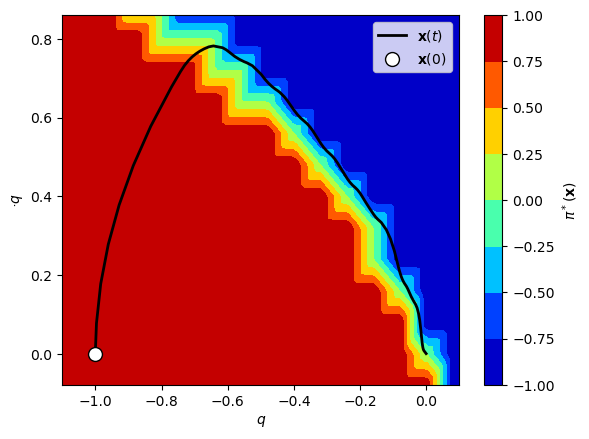

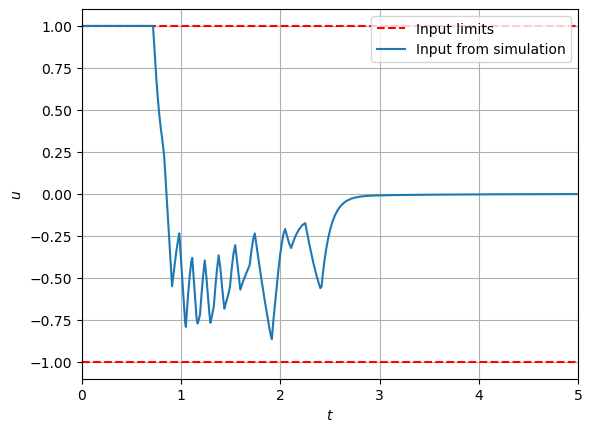

In [9]:
# initial state
q0 = -1.
qdot0 = 0.

# verify that the given initial state is inside the value-iteration grid
assert mesh['q_lim'][0] <= q0 <= mesh['q_lim'][1]
assert mesh['qdot_lim'][0] <= qdot0 <= mesh['qdot_lim'][1]

# duration of the simulation in seconds
sim_time = 5.

# sim and plot
policy = run_value_iteration(cost_function, mesh)[0]
simulate_and_plot(q0, qdot0, sim_time, policy, mesh['u_lim'])

## Implementation of the Closed-Form Solution
Since value iteration didn't give us the results we wanted, in the next cell we ask you to implement [the closed-form solution we've derived in class](https://underactuated.csail.mit.edu/dp.html#minimum_time_double_integrator).
Note that in class we assumed the input to be bounded between $-1$ and $1$, so you can either do the math and generalize that result to generic bounds $u_{\text{min}} < 0$ and $u_{\text{max}} > 0$ (not hard), or double check that `mesh['u_lim']` is still set to `[-1., 1.]`.

**Note 1:**
To help you, we already partially filled the function.
In a small neighborhood of the origin we return $u = - \dot{q} - q$, even if the theoretical solution would say $u = 0$.
This gives the closed-loop dynamics $m \ddot{q} = - q - \dot{q}$ which makes the origin a stable equilibrium.
This trick prevents the controller from chattering wildly between $u_{\text{max}}$ and $u_{\text{min}}$ because of small numerical errors.
Do not cancel it.

**Note 2:**
To complete this function with [the control law from the textbook](https://underactuated.csail.mit.edu/dp.html#minimum_time_double_integrator)
you need to write two conditions on the state $[q, \dot{q}]^T$: one for the full-gas region and one for the full-brake region.
Notice that, momentarily, the function always returns $u = u_{\text{max}}$ if the state is not close to the origin.

In [12]:
def policy_closed_form(q, qdot, atol=1.e-2):
    
    # system in a neighborhood of the origin
    # up to the absolute tolerance atol
    x_norm = np.linalg.norm([q, qdot])
    if np.isclose(x_norm, 0., atol=atol):
    
        # little trick, do not modify: use a stabilizing controller in the 
        # neighborhood of the origin to prevent wild chattering
        return - q - qdot
    
    # full-brake region
    # check if the state of the system is
    # such that u must be set to -1
    elif (qdot >= 0 and q > -0.5*qdot**2) or (qdot < 0 and q >= 0.5*qdot**2): # modify here
        return mesh['u_lim'][0]
    
    # full-gas region
    # if all the others do not apply,
    # u must be set to 1
    else: # modify here
        return mesh['u_lim'][1]

Now we just encapsulate the function you wrote in a Drake `VectorSystem` that can be sent to the simulator.
Does this state trajectory and this control signal look more reasonable than the ones from the value-iteration algorithm? (Question not graded, do not submit.)

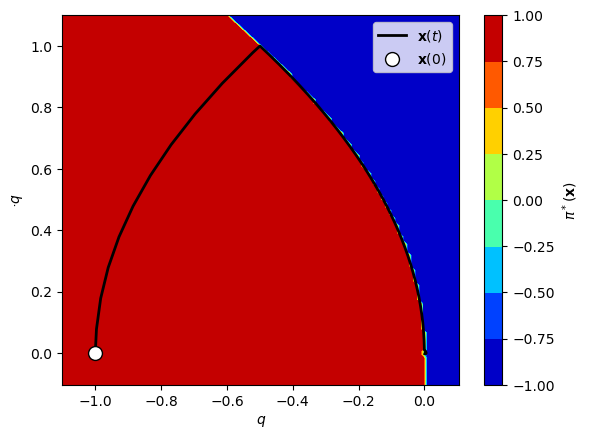

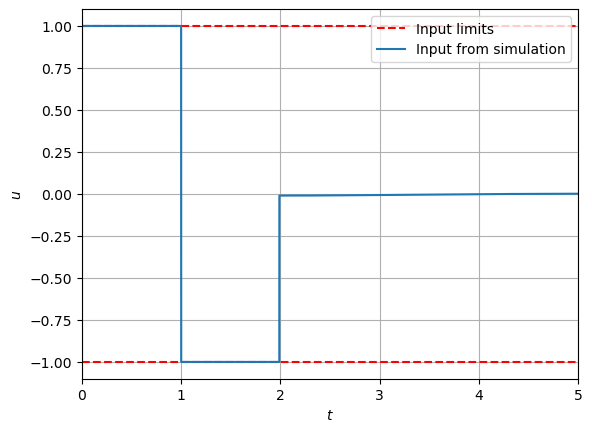

In [13]:
# controller which implements the closed-form solution
class ClosedFormController(VectorSystem):
    
    # two inputs (system state)
    # one output (system input)
    def __init__(self):
        VectorSystem.__init__(self, 2, 1)
        
    # just evaluate the function above
    def DoCalcVectorOutput(self, context, x, controller_state, u):
        u[:] = policy_closed_form(*x)

# sim and plot
simulate_and_plot(q0, qdot0, sim_time, ClosedFormController(), mesh['u_lim'])

## Autograding
You can check your work by running the following cell:

In [14]:
from underactuated.exercises.dp.test_minimum_time import TestMinimumTime
from underactuated.exercises.grader import Grader
Grader.grade_output([TestMinimumTime], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 8/8.

Score for Test closed form policy is 8/8.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bfb65184-600a-42fe-92a1-fc8d01682de5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>